In [1]:
# Setting up Packages
import json
import country_converter as coco
from datetime import datetime, timedelta
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Getting the data
PAYLOAD = {'code': 'ALL'}
URL = 'https://api.statworx.com/covid'
RESPONSE = requests.post(url=URL, data=json.dumps(PAYLOAD))

# Convert the response to a data frame
covid_df = pd.DataFrame.from_dict(json.loads(RESPONSE.text))
covid_df.head(3)

,date,day,month,year,cases,deaths,country,code,population,continentExp,cases_cum,deaths_cum
0,2019-12-31,31,12,2019,0,0,Afghanistan,AF,37172386,Asia,0,0
1,2020-01-01,1,1,2020,0,0,Afghanistan,AF,37172386,Asia,0,0
2,2020-01-02,2,1,2020,0,0,Afghanistan,AF,37172386,Asia,0,0


In [2]:
# Setting the path to the shapefile
SHAPEFILE = 'data/shapefiles/worldmap/ne_10m_admin_0_countries.shp'

# Read shapefile using Geopandas
geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]

# Rename columns.
geo_df.columns = ['country', 'country_code', 'geometry']
geo_df.head(3)

,country,country_code,geometry
0,Indonesia,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Malaysia,MYS,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Chile,CHL,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."


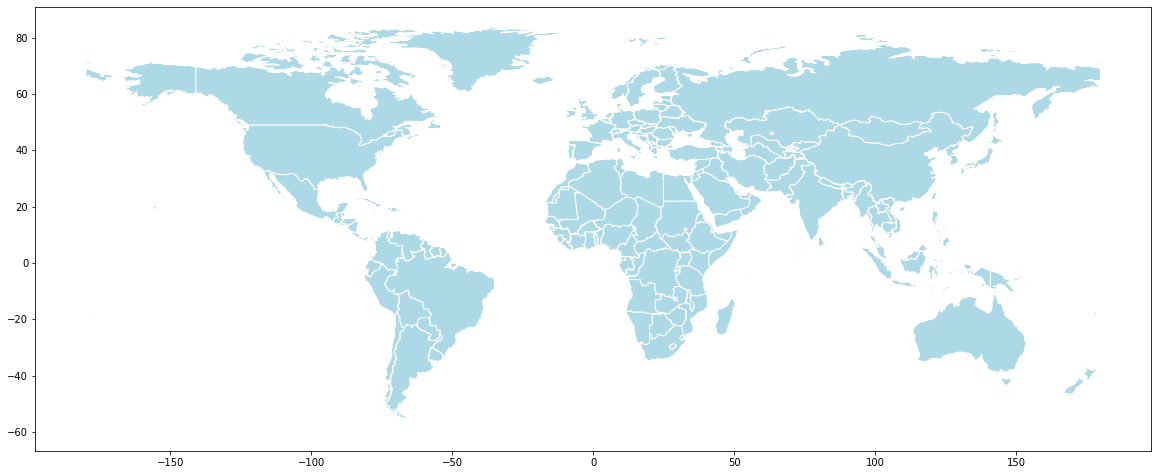

In [7]:
# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)

# Print the map
geo_df.plot(figsize=(20, 20), edgecolor='white', linewidth=1, color='lightblue')

In [3]:
# Next, we need to ensure that our data matches with the country codes. 
iso3_codes = geo_df['country'].to_list()

# Convert to iso3_codes
iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')

# Add the list with iso2 codes to the dataframe
geo_df['iso2_code'] = iso2_codes_list

# There are some countries for which the converter could not find a country code. 
# We will drop these countries.
geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)

In [4]:
# We want to drop the history and only get the data from the last day
d = datetime.today()-timedelta(days=1)
date_yesterday = d.strftime("%Y-%m-%d")

# Preparing the data
covid_df = covid_df[covid_df['date'] == date_yesterday]

# Merge the two dataframes
merged_df = pd.merge(left=geo_df, right=covid_df, how='left', left_on='iso2_code', right_on='code')

# Delete some columns that we won't use
df = merged_df.drop(['day', 'month', 'year', 'country_y', 'code'], axis=1)

#Create the indicator values
df['case_growth_rate'] = round(df['cases']/df['cases_cum'], 2)
df['case_growth_rate'].fillna(0, inplace=True) 
df.head(3)

,country_x,country_code,geometry,iso2_code,date,cases,deaths,population,continentExp,cases_cum,deaths_cum,case_growth_rate
0,Indonesia,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",ID,2020-04-21,185.0,8.0,267663435.0,Asia,6760.0,590.0,0.03
1,Malaysia,MYS,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",MY,2020-04-21,36.0,0.0,31528585.0,Asia,5425.0,89.0,0.01
2,Chile,CHL,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",CL,2020-04-21,419.0,6.0,18729160.0,America,10507.0,139.0,0.04


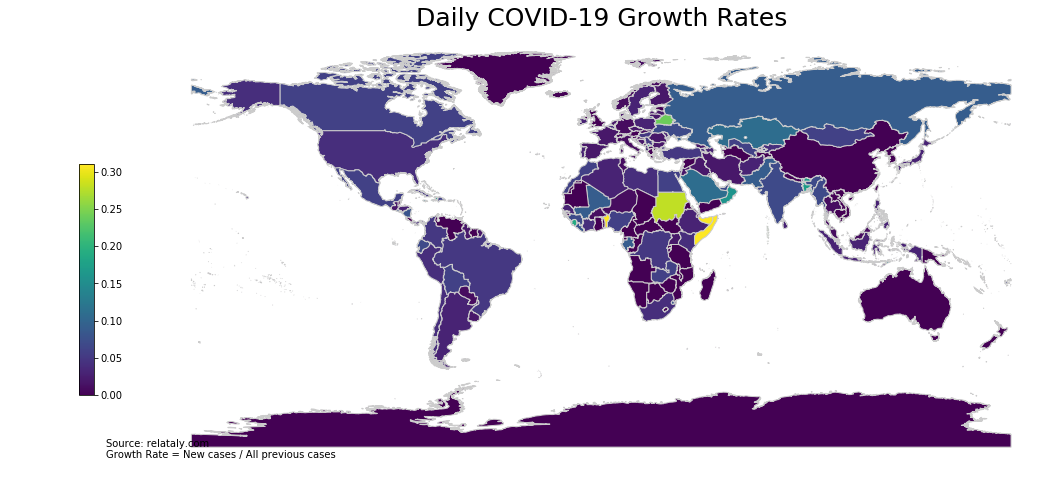

In [5]:
# Print the map
# Set the range for the choropleth
title = 'Daily COVID-19 Growth Rates'
col = 'case_growth_rate'
source = 'Source: relataly.com \nGrowth Rate = New cases / All previous cases'
vmin = df[col].min()
vmax = df[col].max()
cmap = 'viridis'

# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))

# Remove the axis
ax.axis('off')
df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)

# Add a title
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})

# Create an annotation for the data source
ax.annotate(source, xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', 
            verticalalignment='bottom', fontsize=10)
            
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

# Empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

In [38]:
# Safe the map to a png
fig.savefig('map_export.png', dpi=300)

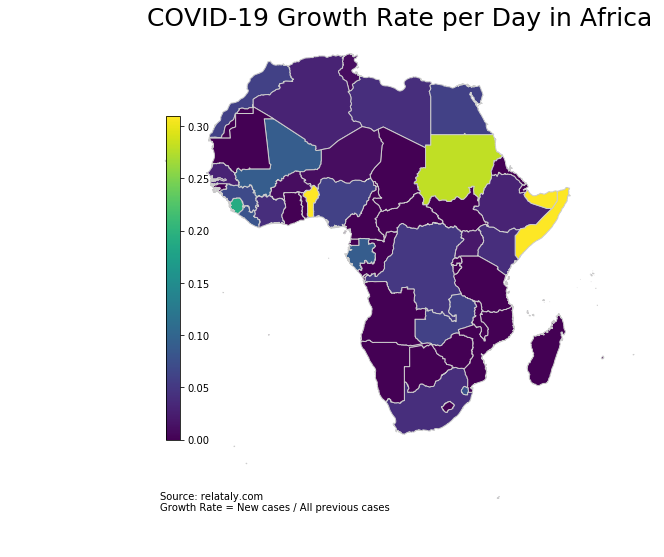

In [24]:
# The map shows that many african countries are currently reporting increasing case numbers
# Next we create a new df based on a filter for african countries
africa_country_list = ['ZM', 'BF', 'TZ', 'EG', 'UG', 'TN', 'TG', 'SZ', 'SD', 
                       'EH', 'SS', 'ZW', 'ZA', 'SO', 'SL', 'SC', 'SN', 'ST', 
                       'SH', 'RW', 'RE', 'GW', 'NG', 'NE', 'NA', 'MZ', 'MA', 
                       'MU', 'MR', 'ML', 'MW', 'MG', 'LY', 'LR', 'LS', 'KE', 
                       'CI', 'GN', 'GH', 'GM', 'GA', 'DJ', 'ER', 'ET', 'GQ', 
                       'BJ', 'CD', 'CG', 'YT', 'KM', 'TD', 'CF', 'CV', 'CM', 
                       'BI', 'BW', 'AO', 'DZ']
africa_map_df = df[df['iso2_code'].isin(africa_country_list)]

# Plot the map for Africa
title = 'COVID-19 Growth Rate per Day in Africa'
col = 'case_growth_rate'
source = 'Source: relataly.com \nGrowth Rate = New cases / All previous cases'
vmin = df[col].min()
vmax = df[col].max()
fig, ax = plt.subplots(1, figsize=(20, 9))
ax.axis('off')
africa_map_df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})
ax.annotate(source, xy=(0.24, .08), xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom', fontsize=10)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
cbaxes = fig.add_axes([0.35, 0.25, 0.01, 0.5])
cbar = fig.colorbar(sm, cax=cbaxes)

In [25]:
africa_map_df

,country_x,country_code,geometry,iso2_code,date,cases,deaths,population,continentExp,cases_cum,deaths_cum,case_growth_rate
12,Ethiopia,ETH,"POLYGON ((34.07070 9.45459, 34.06689 9.53118, ...",ET,2020-04-21,3.0,0.0,109224559.0,Africa,111.0,3.0,0.03
13,South Sudan,SDS,"POLYGON ((35.92084 4.61933, 35.85654 4.61960, ...",SS,2020-04-21,0.0,0.0,10975920.0,Africa,4.0,0.0,0.00
14,Somalia,SOM,"POLYGON ((46.46696 6.53829, 46.48805 6.55864, ...",SO,2020-04-21,73.0,1.0,15008154.0,Africa,237.0,8.0,0.31
15,Kenya,KEN,"MULTIPOLYGON (((34.38119 4.62016, 34.45967 4.6...",KE,2020-04-21,11.0,0.0,51393010.0,Africa,281.0,14.0,0.04
17,Malawi,MWI,"MULTIPOLYGON (((34.96461 -11.57356, 34.65125 -...",MW,2020-04-21,0.0,0.0,18143315.0,Africa,17.0,2.0,0.00
18,United Republic of Tanzania,TZA,"MULTIPOLYGON (((32.92086 -9.40790, 32.90546 -9...",TZ,2020-04-21,0.0,0.0,56318348.0,Africa,170.0,5.0,0.00
20,Somaliland,SOL,"POLYGON ((48.93911 11.24913, 48.93911 11.13674...",SO,2020-04-21,73.0,1.0,15008154.0,Africa,237.0,8.0,0.31
26,Morocco,MAR,"POLYGON ((-8.81703 27.66146, -8.81845 27.65940...",MA,2020-04-21,191.0,2.0,36029138.0,Africa,3046.0,143.0,0.06
27,Western Sahara,SAH,"POLYGON ((-8.81703 27.66146, -8.81654 27.66147...",EH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
30,Republic of the Congo,COG,"POLYGON ((18.62639 3.47687, 18.63455 3.44922, ...",CG,2020-04-21,0.0,0.0,5244363.0,Africa,160.0,6.0,0.00


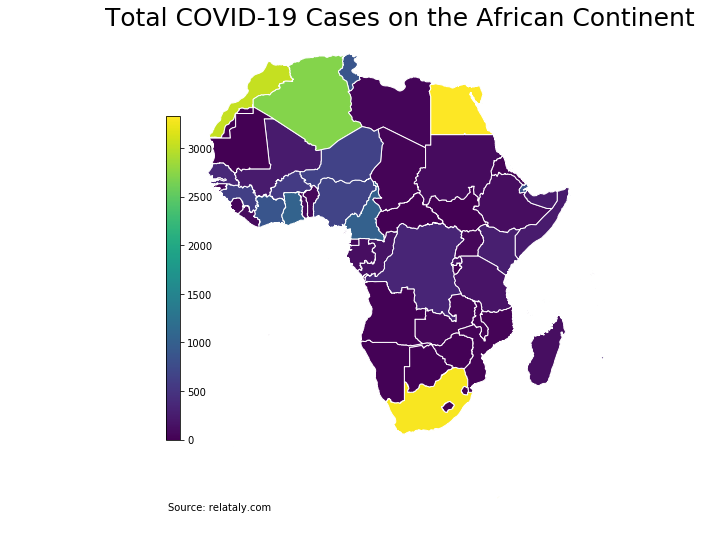

In [36]:
# Insert cases per population
# Alternative: africa_map_df2['cases_population'] = round(africa_map_df['cases_cum'] / africa_map_df['population'] * 100)
africa_map_df2 = africa_map_df.copy()

# Remove NAs
africa_map_df2.loc[: , 'cases_cum'].fillna(0, inplace=True)
# Show the data
africa_map_df2.head()

# Plot the map
title = 'Total COVID-19 Cases on the African Continent'
col = 'cases_cum'
source = 'Source: relataly.com '
vmin = africa_map_df2[col].min()
vmax = africa_map_df2[col].max()
fig, ax = plt.subplots(1, figsize=(20, 9))
ax.axis('off')
africa_map_df2.plot(column=col, ax=ax, edgecolor='1', linewidth=1, cmap=cmap)
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate(
    source, xy=(0.24, .08), xycoords='figure fraction', horizontalalignment='left', 
    verticalalignment='bottom', fontsize=10)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
cbaxes = fig.add_axes([0.35, 0.25, 0.01, 0.5])
cbar = fig.colorbar(sm, cax=cbaxes)

In [26]:
#Filter country codes
eu_country_list = ('IM', 'JE', 'GG', 'GB', 'MK', 'UA', 'TR', 'CH', 'SE', 'SJ', 
                   'ES', 'SI', 'SK', 'RS', 'SM', 'RO', 'PT', 'PL', 'NO', 'NL', 
                   'ME', 'MD', 'MC', 'MT', 'LU', 'LT', 'LI', 'LV', 'IT', 'IE', 
                   'IS', 'HU', 'VA', 'GR', 'GI', 'DE', 'GE', 'FR', 'AX', 'FI', 
                   'FO', 'EE', 'DK', 'CZ', 'CY', 'HR', 'BY', 'BG', 'BA', 'BE', 
                   'AM', 'AT', 'AZ', 'AD', 'AL')
eu_map_df = df[df['iso2_code'].isin(eu_country_list)]

In [28]:
#Calculate and insert cases per population
eu_map_df.insert(
    1, 'cases_population', 
    round(eu_map_df['cases_cum'] / eu_map_df['population']*100, 5), True)
eu_map_df.loc[:, 'cases_population'].fillna(0, inplace=True)

C:\Users\Flo7u\Anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


C:\Users\Flo7u\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


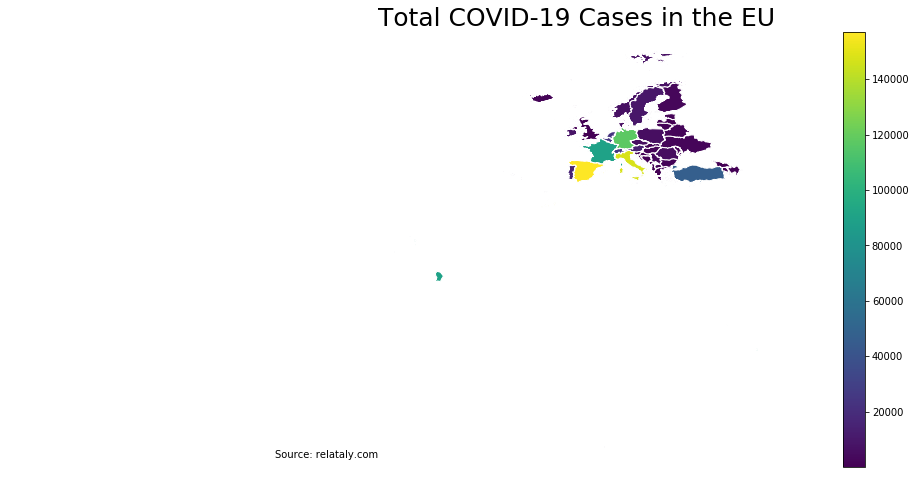

In [76]:
# set the range for the choropleth
title = 'Total COVID-19 Cases in the EU'
col = 'cases_cum'
source = 'Source: relataly.com'
vmin = eu_map_df[col].min()
vmax = eu_map_df[col].max()
fig, ax = plt.subplots(1, figsize=(24, 8))
ax.axis('off')
eu_map_df.plot(column=col, cmap=cmap, ax=ax, edgecolor='1', linewidth=1)
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight':'3'})
ax.annotate(
    source, xy=(0.3, .08), xycoords='figure fraction', 
    horizontalalignment='left', verticalalignment='bottom', fontsize=10)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
# empty array for the data range
sm._A = []
cbar = fig.colorbar(sm)